In [1]:
import numpy as np
from FastCCM import CCM
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import get_truncated_lorenz_rand
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from manifold_learning import imd_nd_smap, imd_1d_smap
from sklearn.decomposition import PCA
import importlib
importlib.reload(imd_nd_smap)
importlib.reload(CCM)

<module 'FastCCM.CCM' from '/home/iaroslav/Documents/Python projects/FastCCM/src/FastCCM/CCM.py'>

In [2]:
import cv2
import numpy as np

def video_to_numpy_array(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Convert the frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Calculate the new width while keeping the aspect ratio
        original_height, original_width = gray_frame.shape[:2]
        new_height = 128
        aspect_ratio = original_width / original_height
        new_width = int(new_height * aspect_ratio)
        
        # Resize the frame
        resized_frame = cv2.resize(gray_frame, (new_width, new_height))
        # Append the frame to the list
        frames.append(resized_frame)

    cap.release()

    # Convert the list of frames to a NumPy array
    video_array = np.array(frames)
    return video_array

# Load the video
video_path = "../src/manifold_learning/data/datasets/waterwheel.mp4"  # Replace with your video file path
video_array = video_to_numpy_array(video_path)

print("Video shape:", video_array.shape)  # (num_frames, height, width)


Video shape: (3117, 128, 227)


In [3]:
mask = (video_array.mean(axis=0) > 5)
X = video_array[:2400,mask]

In [4]:
rand_mask = (np.random.uniform(0,1,size=X.shape[1]) < 1)
rand_observables = X[:,rand_mask]

In [6]:
observables = X / X.max()
#observables = np.diff(observables,axis=0)
#observables = utils.get_td_embedding_np(observables,5,1).mean(axis=1)
A = np.random.normal(0,0.03,(observables.shape[1],500))
observables = observables @ A

#observables = np.diff(observables,axis=0)

In [5]:

observables = rand_observables
observables = np.log(1 + observables)
#observables = observables / observables.max()
#bservables = utils.get_td_embedding_np(observables,5,1).mean(axis=1)
observables -= observables.mean(axis=0)
observables /= observables.std(axis=0)
observables = observables[:,np.isnan(observables).sum(axis=0)==0]
#observables = np.diff(observables,axis=0)

In [7]:

observables = utils.get_td_embedding_np(observables,3,1).reshape(-1,3*observables.shape[1])

In [8]:
trainer = imd_nd_smap.IMD_nD_smap(observables.shape[1], embed_dim=20, n_components=4, subtract_corr=False, device="cuda")



In [1644]:
trainer = imd_1d_smap.IMD_1D_smap(observables.shape[1], embed_dim=3, embed_lag=8, n_components=5, subtract_corr=True, device="cuda")


In [9]:
trainer.fit(observables, sample_len=150, library_len=800, 
            exclusion_rad=6, theta=8, tp=6, 
            epochs=500, num_batches=16,optimizer="Adagrad", learning_rate=0.01, tp_policy="range",loss_mask_size=3)
            


Epoch 1/500, Loss: 0.9851
Epoch 2/500, Loss: 0.9823
Epoch 3/500, Loss: 0.9283
Epoch 4/500, Loss: 0.8923
Epoch 5/500, Loss: 0.8239
Epoch 6/500, Loss: 0.7801
Epoch 7/500, Loss: 0.7010
Epoch 8/500, Loss: 0.6754
Epoch 9/500, Loss: 0.5873
Epoch 10/500, Loss: 0.5417
Epoch 11/500, Loss: 0.5124
Epoch 12/500, Loss: 0.4435
Epoch 13/500, Loss: 0.4439
Epoch 14/500, Loss: 0.4102
Epoch 15/500, Loss: 0.3761
Epoch 16/500, Loss: 0.3450
Epoch 17/500, Loss: 0.3314
Epoch 18/500, Loss: 0.3318
Epoch 19/500, Loss: 0.2988
Epoch 20/500, Loss: 0.2891
Epoch 21/500, Loss: 0.2979
Epoch 22/500, Loss: 0.2687
Epoch 23/500, Loss: 0.2572
Epoch 24/500, Loss: 0.2796
Epoch 25/500, Loss: 0.2316
Epoch 26/500, Loss: 0.2391
Epoch 27/500, Loss: 0.2283
Epoch 28/500, Loss: 0.2148
Epoch 29/500, Loss: 0.2123
Epoch 30/500, Loss: 0.2122
Epoch 31/500, Loss: 0.2140
Epoch 32/500, Loss: 0.1884
Epoch 33/500, Loss: 0.1981
Epoch 34/500, Loss: 0.1907
Epoch 35/500, Loss: 0.1649
Epoch 36/500, Loss: 0.1707
Epoch 37/500, Loss: 0.1760
Epoch 38/5

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

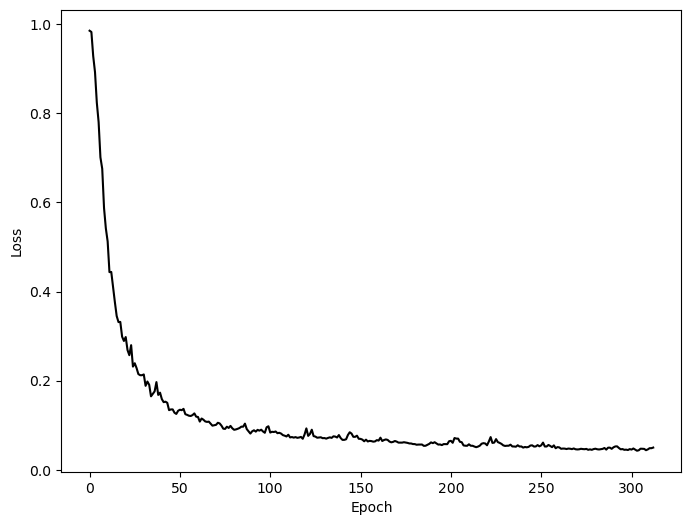

In [10]:
plt.figure(figsize=(8,6),dpi=100)
plt.plot(trainer.get_loss_history()[:],color="black")
plt.xlabel("Epoch")
plt.ylabel("Loss")


In [11]:

unmixed = (trainer.predict(observables))

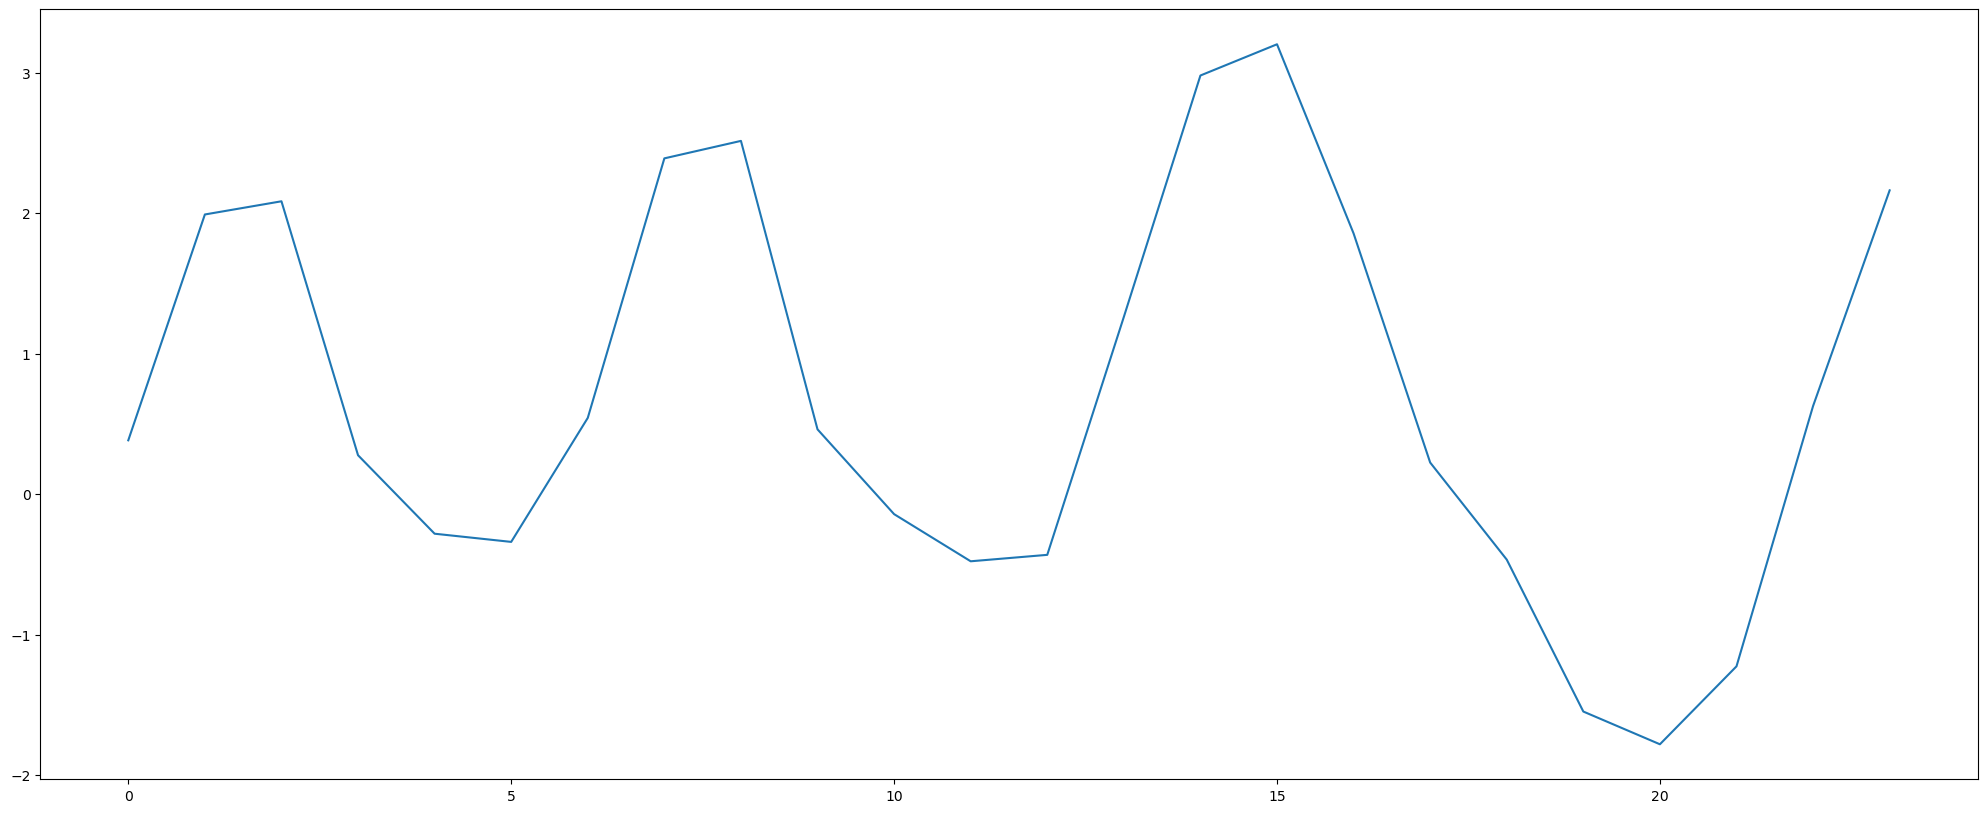

In [12]:
plt.figure(figsize=(25,10))
plt.plot(unmixed[:24,2,7])

In [13]:
utils.calculate_correlation_dimension(unmixed[:,0])

4.081989765167236

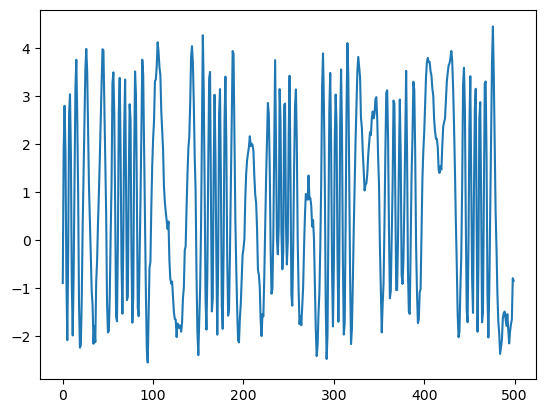

In [14]:
plt.plot((unmixed[:500,2,0]))

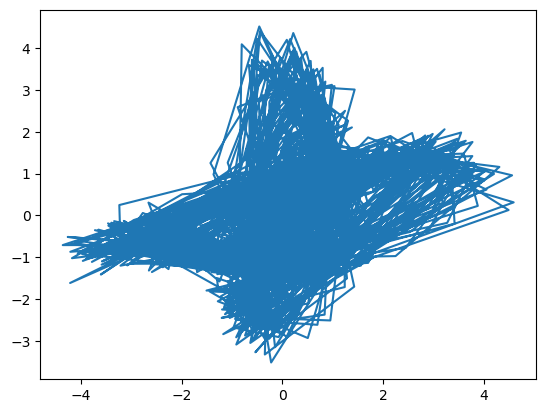

In [15]:
plt.plot(np.diff(unmixed[:,2,1]),np.diff(unmixed[:,2,2]))

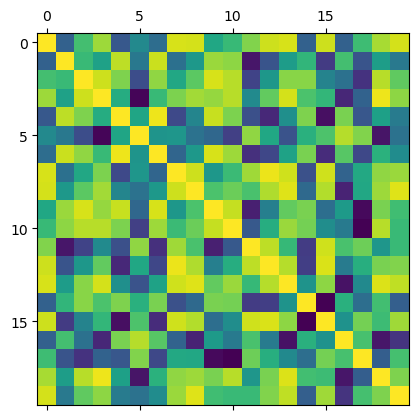

In [16]:
plt.matshow(np.abs(np.corrcoef(unmixed[:,2,:].T)))

In [17]:

def compute_speed_of_rotation(X, t):
    # Calculate time differences
    dt = np.diff(t)
    
    # Calculate velocity components (central differences)
    V = np.diff(X, axis=0) / dt[:, None]
    
    # Calculate the speed of rotation (magnitude of velocity vector)
    speed = np.linalg.norm(V, axis=1)
    
    # Return the speed time series
    return speed, t[:-1] 


import plotly.graph_objects as go
x_pca = PCA(3,whiten=True).fit_transform(StandardScaler().fit_transform(unmixed[:,1,:]))
fig = go.Figure(
    data=go.Scatter3d(
        x=x_pca[:-1, 0],
        y=x_pca[:-1, 1],
        z=x_pca[:-1, 2],
        mode='lines',
        line=dict(
            color=compute_speed_of_rotation(x_pca,np.arange(0,unmixed.shape[0])/25)[0],  # Color by order
            colorscale='Viridis',  # Choose a colorscale
            colorbar=dict(title='Velocity'),  # Add colorbar
            width=4  # Line width
        )
    )
)
# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    height=700
)
fig.show()

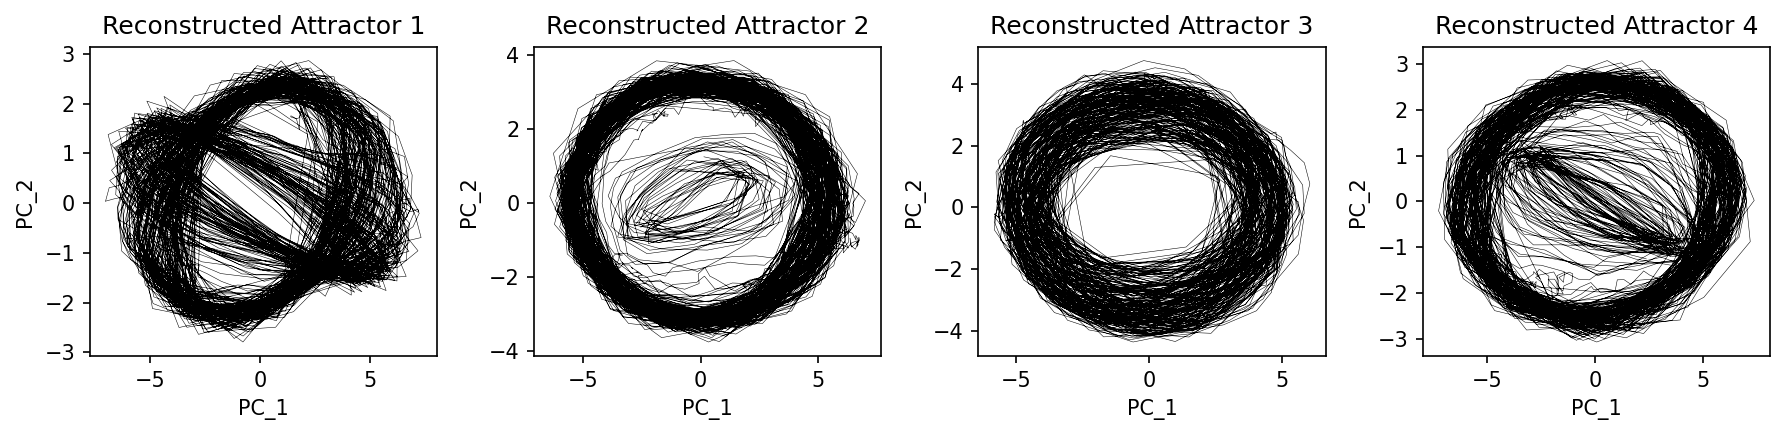

In [18]:
# Assuming 'unmixed' is your data array with shape (n_samples, n_systems, 2)
plt.figure(figsize=(3 * unmixed.shape[1], 3),dpi=150)

for i in range(unmixed.shape[1]):
    plt.subplot(1, unmixed.shape[1], i + 1)
    pca = PCA()
    x_pca = pca.fit_transform(StandardScaler().fit_transform(unmixed[:,i,:]))
    plt.plot(x_pca[:,0],x_pca[:,1],linewidth=0.25,color="black")
    plt.title(f"Reconstructed Attractor {i + 1}")
    plt.xlabel('PC_1')
    plt.ylabel('PC_2')

plt.tight_layout()
plt.show()

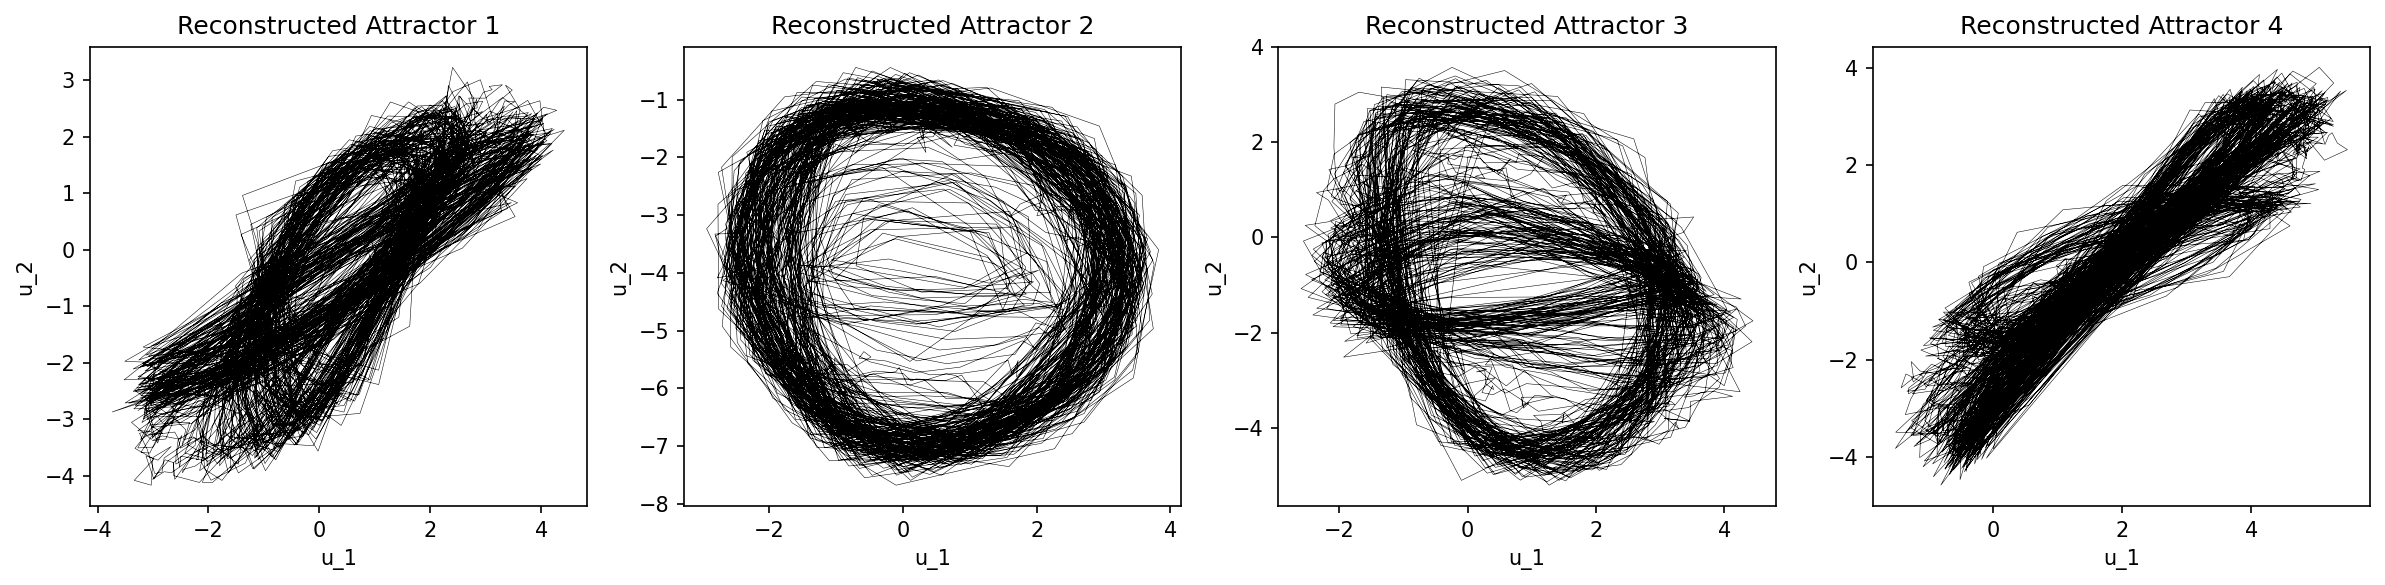

In [19]:
# Assuming 'unmixed' is your data array with shape (n_samples, n_systems, 2)
plt.figure(figsize=(4 * unmixed.shape[1], 4),dpi=150)

for i in range(unmixed.shape[1]):
    plt.subplot(1, unmixed.shape[1], i + 1)
    plt.plot(unmixed[:, i, 0], unmixed[:, i, 1], linewidth=0.25,color="black")
    plt.title(f"Reconstructed Attractor {i + 1}")
    plt.xlabel('u_1')
    plt.ylabel('u_2')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Learned projections')

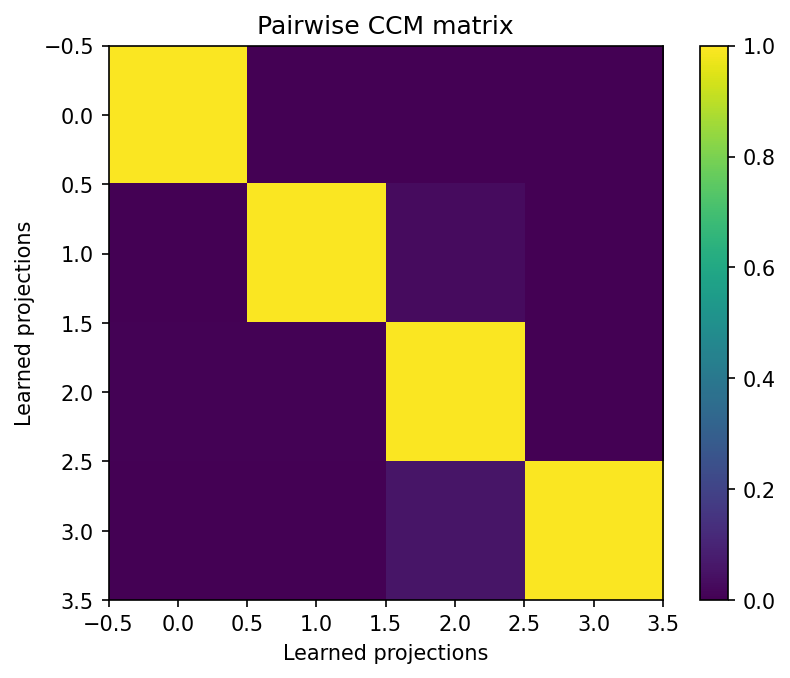

In [20]:
ccm_matrix_unmixed = CCM.PairwiseCCM().compute(
    np.transpose(unmixed, axes=(1, 0, 2)),
    np.transpose(unmixed, axes=(1, 0, 2)),
    1500, 400, 60, 0,
    method="simplex",
    nbrs_num=15,
).mean(axis=0)
plt.figure(dpi=150)
plt.imshow(ccm_matrix_unmixed, vmin=0, vmax=1)
plt.colorbar()
plt.title("Pairwise CCM matrix")
plt.xlabel("Learned projections")
plt.ylabel("Learned projections")


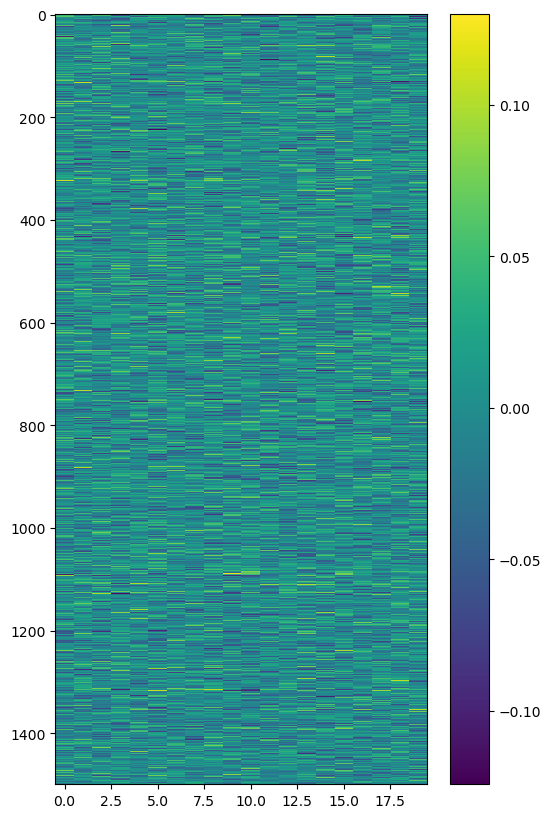

In [21]:

plt.figure(figsize=(6,10))
plt.imshow((trainer.model.get_weights()[:,0]),aspect="auto",interpolation="nearest")
plt.colorbar()

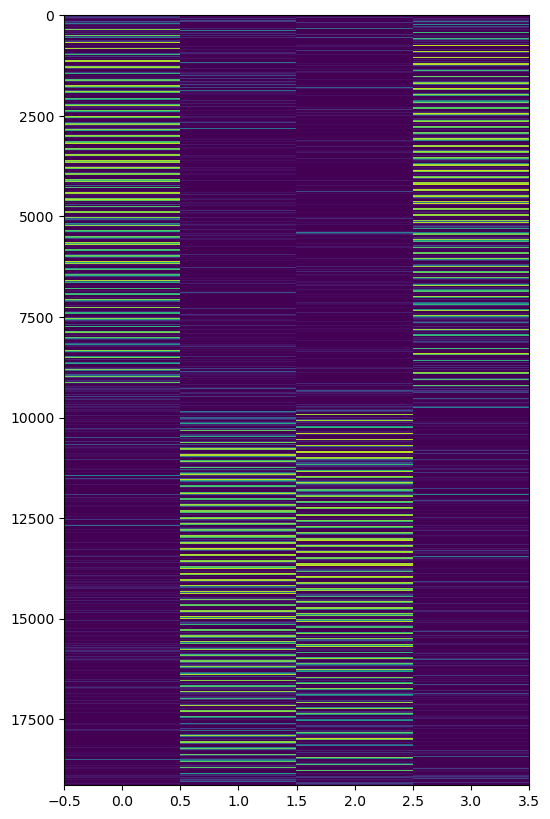

In [22]:
plt.figure(figsize=(6,10))
unmixed_xmap_X = [np.mean([CCM.PairwiseCCM().compute(np.transpose((unmixed[:,[i]]),axes=(1,0,2)),rand_observables.T[:X.shape[1],:,None],500,100,20,0,method="simplex",nbrs_num=7,).mean(axis=0) for exp in range(5)] ,axis=0) for i in range(unmixed.shape[1])]
unmixed_xmap_X = np.array(unmixed_xmap_X).T[0]
plt.imshow(unmixed_xmap_X,vmin=0,vmax=1,aspect="auto",interpolation="nearest")

/home/iaroslav/miniconda3/lib/python3.12/site-packages/matplotlib/cm.py:489: RuntimeWarning:

invalid value encountered in cast



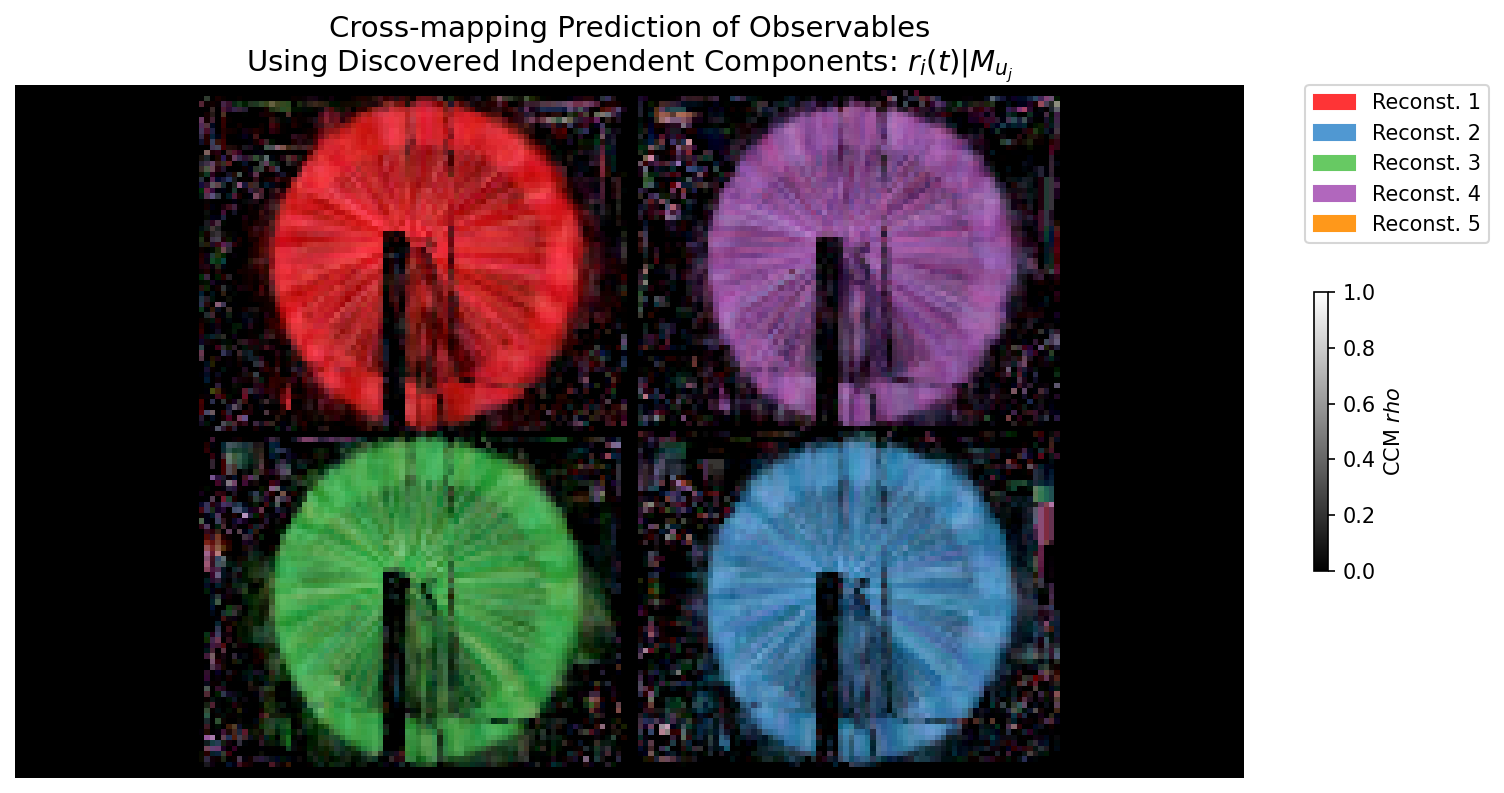

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Initialize composite color image
color_image = np.zeros((*video_array.shape[1:], 3))  # RGB image

# Define colors for each component (R, G, B, etc.)
colors = [
    [0.994118, 0.201961, 0.209804],  # Brighter Red
    [0.315686, 0.594118, 0.821569],  # Brighter Blue
    [0.401961, 0.786275, 0.390196],  # Brighter Green
    [0.696078, 0.405882, 0.739216],  # Brighter Purple
    [1.000000, 0.598039, 0.100000]   # Brighter Orange
]

# Labels for legend
labels = [
    "Reconst. 1",
    "Reconst. 2",
    "Reconst. 3",
    "Reconst. 4",
    "Reconst. 5"
]

# Map each component to its color
for i in range(4):
    z = np.zeros(video_array.shape[1:])
    zz = np.zeros(rand_mask.shape)
    zz[rand_mask] = unmixed_xmap_X[:, i]
    z[mask] = zz
    color_image += np.expand_dims(z, axis=-1) * np.array(colors[i])

# Clip values to [0, 1] to avoid overflow
color_image = np.clip(color_image, 0, 1)

# Calculate intensity (grayscale equivalent of the RGB image)
intensity_image = np.dot(color_image, [0.2989, 0.5870, 0.1140])  # Convert RGB to grayscale

# Plot the composite image
fig, ax = plt.subplots(figsize=(15,6),dpi=150)
im = ax.imshow(color_image)
ax.axis('off')
ax.set_title("Cross-mapping Prediction of Observables\nUsing Discovered Independent Components: $r_i(t) | M_{u_j}$",fontsize=14)

# Create legend
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Add a colorbar for intensity
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap='gray', norm=plt.Normalize(vmin=0, vmax=1)),
    ax=ax,
    orientation='vertical',
    fraction=0.008,
    pad=0.04,
)
cbar.set_label('CCM ${rho}$')

plt.show()


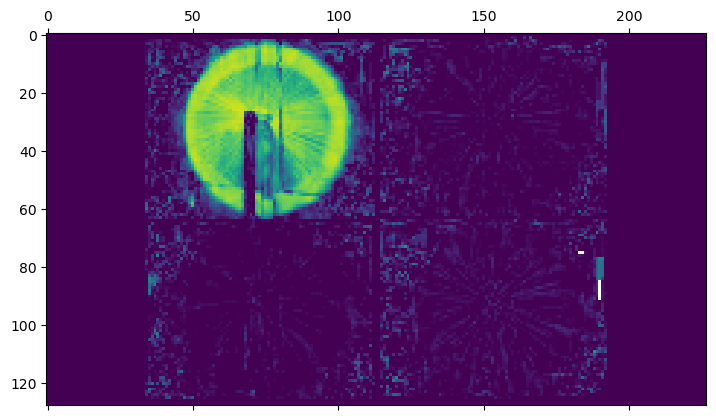

In [24]:
z = np.zeros(video_array.shape[1:])
zz = np.zeros(rand_mask.shape)

zz[rand_mask] = unmixed_xmap_X[:,0]
z[mask] = zz
plt.matshow(z,vmax=1,vmin=0)



In [25]:
gen_observ = []
gen_latent = []
ttp = 1
temp = observables[-ttp:]
for i in range(int(1500/ttp)):
    temp_, temp = trainer.generate(observables[:-ttp*2],temp,theta=5,exclusion_rad=30,tp=ttp)
    gen_observ += [temp]
    gen_latent += [np.transpose(temp_,(1,0,2))]
gen_observ = np.concatenate(gen_observ)
gen_latent = np.concatenate(gen_latent)

KeyboardInterrupt: 

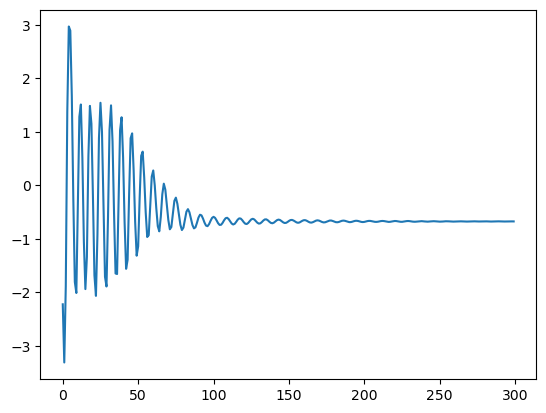

In [139]:
plt.plot(gen_latent[:300,0,0])

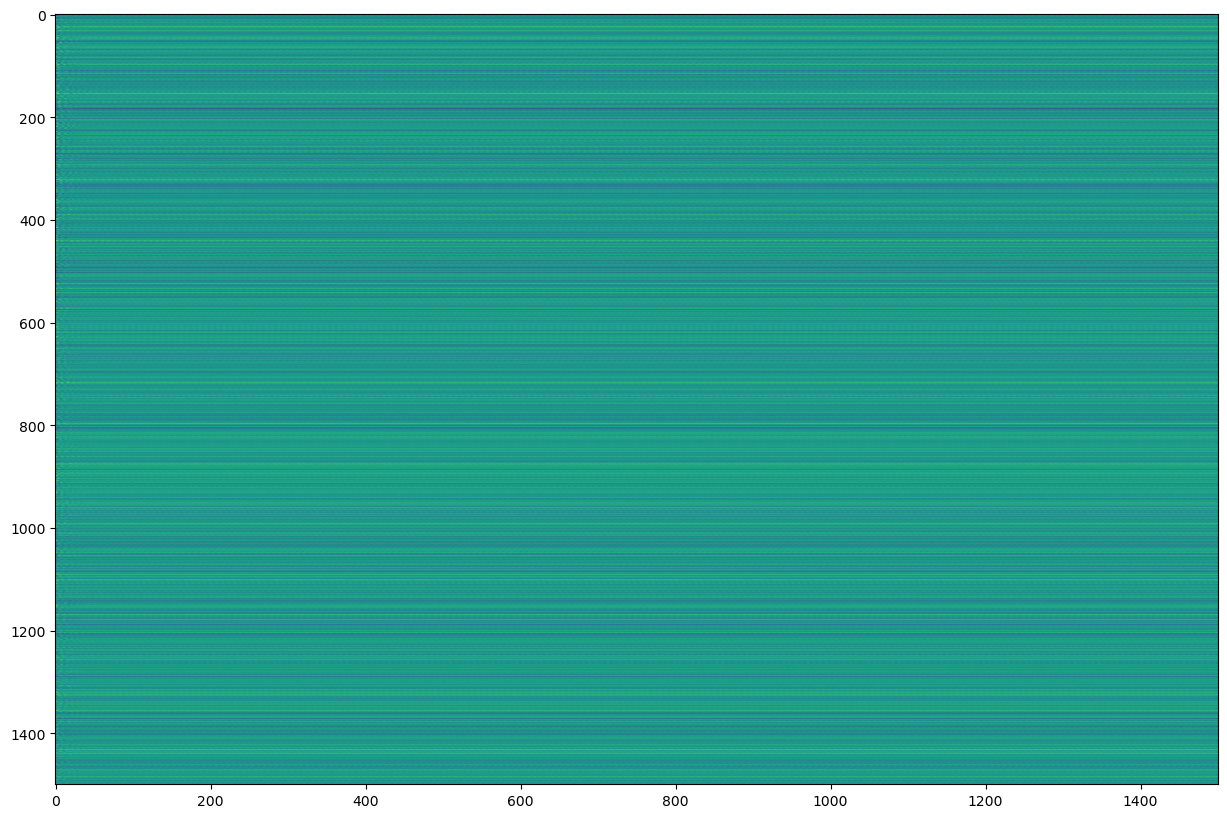

In [209]:

plt.figure(figsize=(15,10))
plt.imshow(gen_observ.T,aspect="auto")

In [3118]:
observables_ = unmixed.reshape(-1,5*10)

In [3119]:

observables_ = utils.get_td_embedding_np(observables_,2,10).reshape(-1,2*observables_.shape[1])

In [3120]:
trainer_ = imd_nd_smap.IMD_nD_smap(observables_.shape[1], embed_dim=3, n_components=5, subtract_corr=False, device="cuda")



In [3121]:
trainer_.fit(observables_, sample_len=150, library_len=500, 
            exclusion_rad=20, theta=5, tp=10, 
            epochs=1000, num_batches=32,optimizer="Adagrad", learning_rate=0.01, tp_policy="range",loss_mask_size=3)
            


Epoch 1/1000, Loss: 0.9295
Epoch 2/1000, Loss: 0.8970
Epoch 3/1000, Loss: 0.8634
Epoch 4/1000, Loss: 0.8454
Epoch 5/1000, Loss: 0.8200
Epoch 6/1000, Loss: 0.8039
Epoch 7/1000, Loss: 0.7946
Epoch 8/1000, Loss: 0.7775
Epoch 9/1000, Loss: 0.7598
Epoch 10/1000, Loss: 0.7447
Epoch 11/1000, Loss: 0.7369
Epoch 12/1000, Loss: 0.7036
Epoch 13/1000, Loss: 0.7238
Epoch 14/1000, Loss: 0.7125
Epoch 15/1000, Loss: 0.6945
Epoch 16/1000, Loss: 0.6735
Epoch 17/1000, Loss: 0.6651
Epoch 18/1000, Loss: 0.6611
Epoch 19/1000, Loss: 0.6692
Epoch 20/1000, Loss: 0.6609
Epoch 21/1000, Loss: 0.6543
Epoch 22/1000, Loss: 0.6448
Epoch 23/1000, Loss: 0.6447
Epoch 24/1000, Loss: 0.6179
Epoch 25/1000, Loss: 0.6264
Epoch 26/1000, Loss: 0.6308
Epoch 27/1000, Loss: 0.6370
Epoch 28/1000, Loss: 0.6063
Epoch 29/1000, Loss: 0.6309
Epoch 30/1000, Loss: 0.6193
Epoch 31/1000, Loss: 0.6172
Epoch 32/1000, Loss: 0.6060
Epoch 33/1000, Loss: 0.5874
Epoch 34/1000, Loss: 0.6048
Epoch 35/1000, Loss: 0.5877
Epoch 36/1000, Loss: 0.5993
E

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

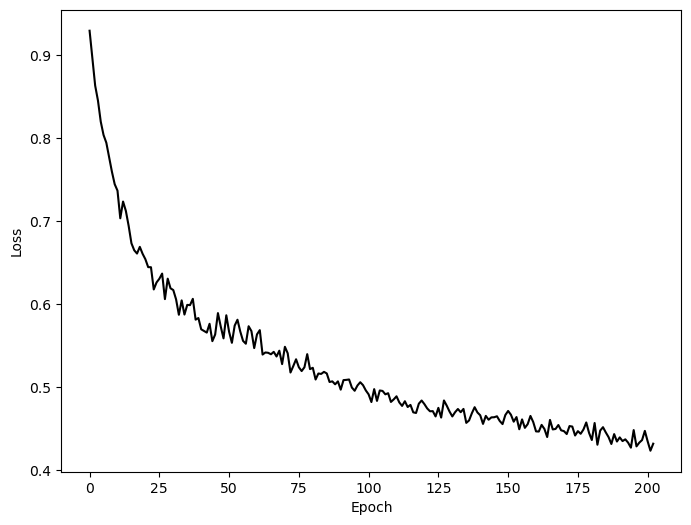

In [3122]:
plt.figure(figsize=(8,6),dpi=100)
plt.plot(trainer_.get_loss_history()[:],color="black")
plt.xlabel("Epoch")
plt.ylabel("Loss")


In [3123]:

unmixed_ = trainer_.predict(observables_)

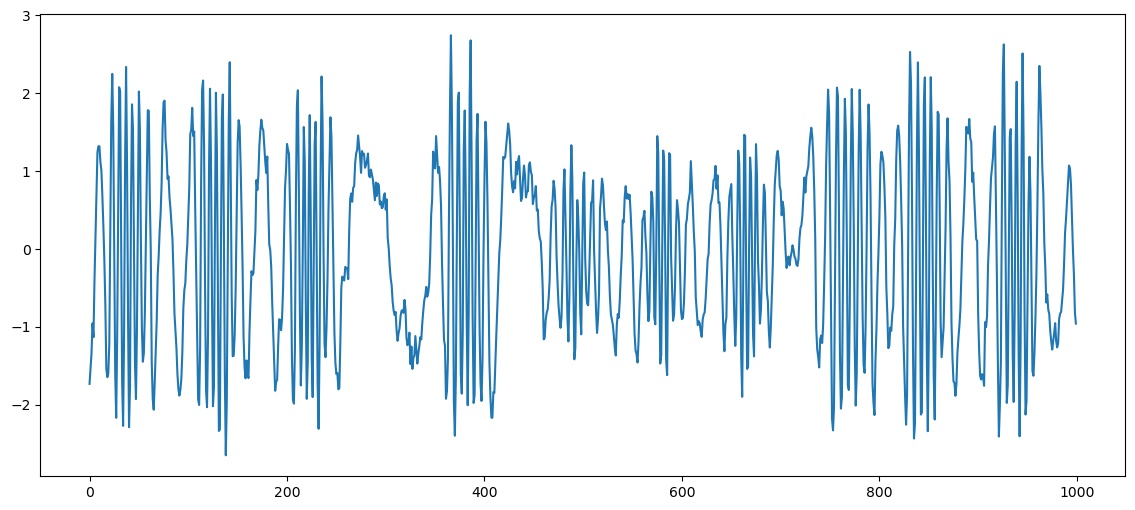

In [3124]:
plt.figure(figsize=(14,6))
plt.plot(unmixed_[:1000,4,1])

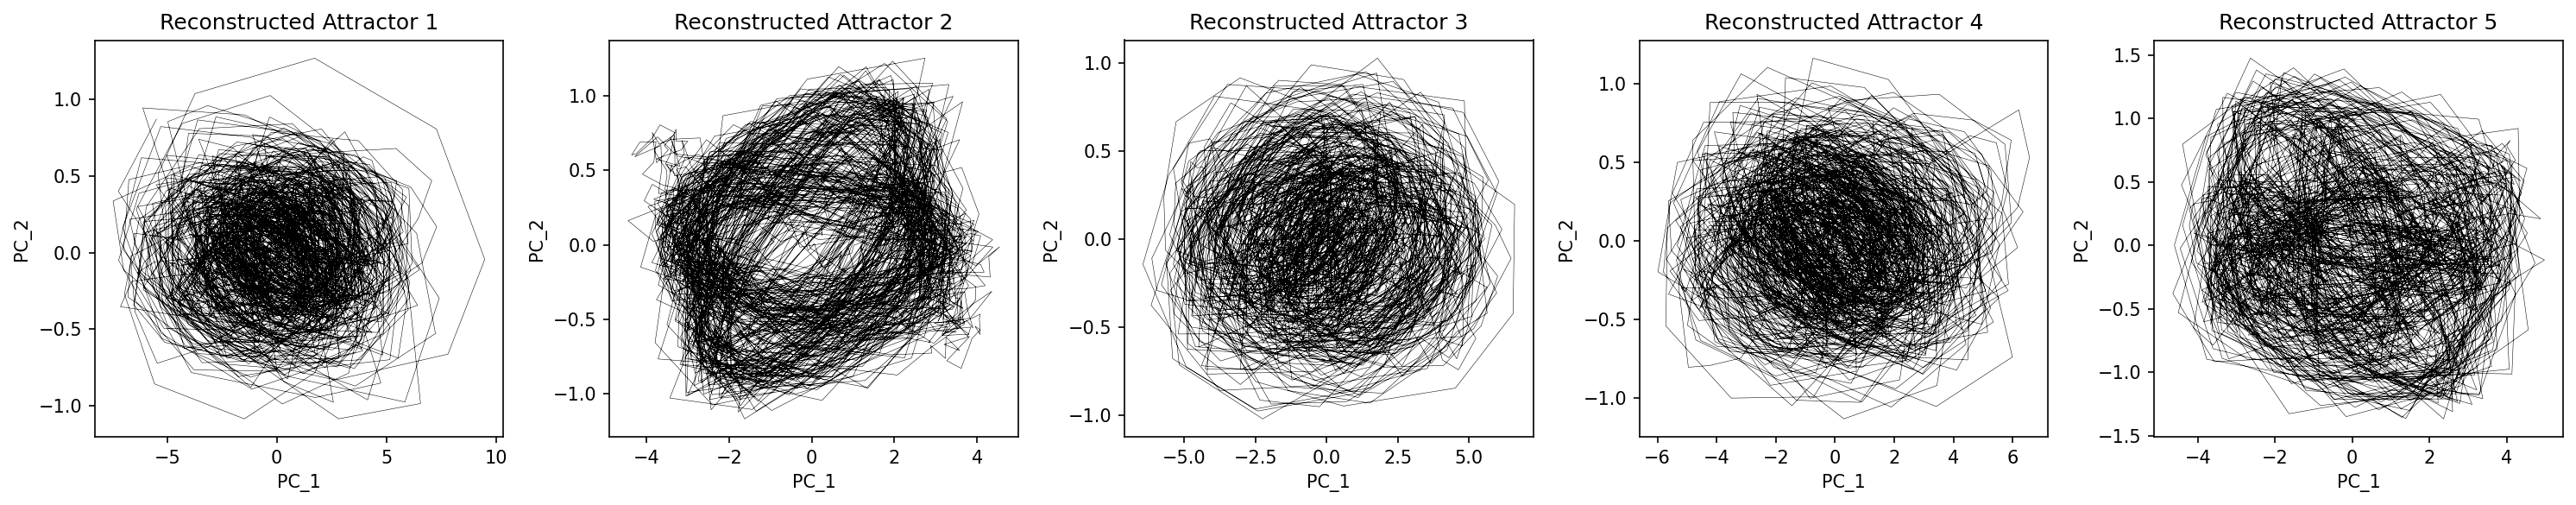

In [3125]:
# Assuming 'unmixed' is your data array with shape (n_samples, n_systems, 2)
plt.figure(figsize=(4 * unmixed_.shape[1], 4),dpi=150)

for i in range(unmixed_.shape[1]):
    plt.subplot(1, unmixed_.shape[1], i + 1)
    x_pca = PCA(2).fit_transform(unmixed_[:,i,:])
    plt.plot(x_pca[:,0],x_pca[:,1],linewidth=0.25,color="black")
    plt.title(f"Reconstructed Attractor {i + 1}")
    plt.xlabel('PC_1')
    plt.ylabel('PC_2')

plt.tight_layout()
plt.show()

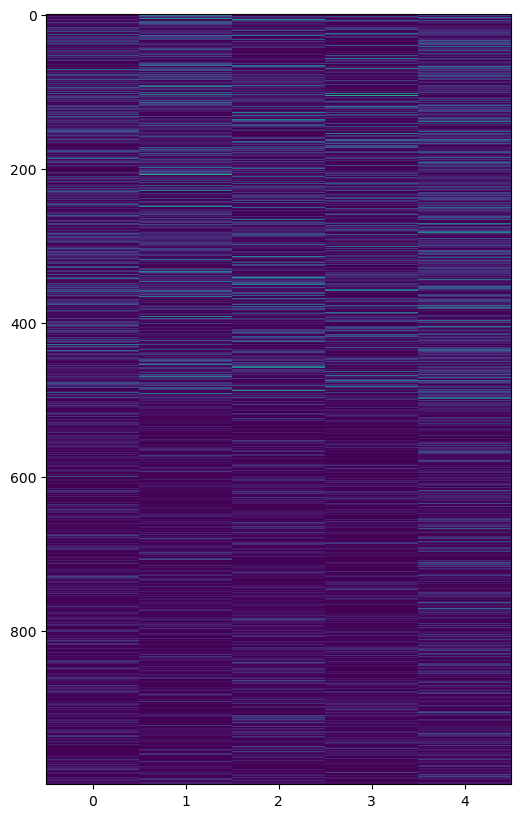

In [3126]:
plt.figure(figsize=(6,10))
unmixed_xmap_X = [np.mean([CCM.PairwiseCCM().compute(np.transpose(unmixed_[:,[i]],axes=(1,0,2)),observables.T[:X.shape[1],:,None],500,100,20,0,method="simplex",nbrs_num=7,).mean(axis=0) for exp in range(5)] ,axis=0) for i in range(unmixed_.shape[1])]
unmixed_xmap_X = np.array(unmixed_xmap_X).T[0]
plt.imshow(unmixed_xmap_X,vmin=0,vmax=1,aspect="auto",interpolation="nearest")

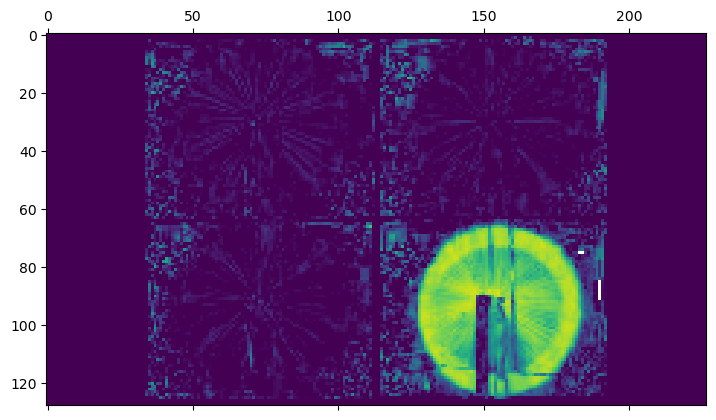

In [215]:
z = np.zeros(video_array.shape[1:])
zz = np.zeros(rand_mask.shape)

zz[rand_mask] = unmixed_xmap_X[:,4]
z[mask] = zz
plt.matshow(z,vmax=1,vmin=0)


In [227]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out, _ = self.rnn(x)  # RNN forward pass
        out = self.fc(out[:, -1, :])  # Fully connected layer on the last time step
        return out

# Generate synthetic 10-dimensional chaotic time series (e.g., Lorenz system)
def generate_chaotic_time_series(n_points, n_dims):
    # Example: using random values for simplicity; replace with actual chaotic data
    return np.random.rand(n_points, n_dims)

# Prepare data
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Hyperparameters
input_dim = 10  # Number of dimensions in the time series
hidden_dim = 5
output_dim = 10  # Same as input_dim for prediction
num_layers = 1
sequence_length = 15
epochs = 50
batch_size = 32
learning_rate = 0.01

# Generate and prepare data
n_points = 10000
time_series = unmixed[:,2]
X, y = create_sequences(time_series, sequence_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Create train/test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
model = RNNModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

# Test the model
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")


Epoch [1/50], Loss: 3.8696
Epoch [2/50], Loss: 3.0238
Epoch [3/50], Loss: 2.6427
Epoch [4/50], Loss: 2.3719
Epoch [5/50], Loss: 2.1470
Epoch [6/50], Loss: 1.9672
Epoch [7/50], Loss: 1.8158
Epoch [8/50], Loss: 1.6900
Epoch [9/50], Loss: 1.5809
Epoch [10/50], Loss: 1.4882
Epoch [11/50], Loss: 1.4028
Epoch [12/50], Loss: 1.3302
Epoch [13/50], Loss: 1.2627
Epoch [14/50], Loss: 1.2043
Epoch [15/50], Loss: 1.1487
Epoch [16/50], Loss: 1.0995
Epoch [17/50], Loss: 1.0532
Epoch [18/50], Loss: 1.0111
Epoch [19/50], Loss: 0.9729
Epoch [20/50], Loss: 0.9382
Epoch [21/50], Loss: 0.9025
Epoch [22/50], Loss: 0.8713
Epoch [23/50], Loss: 0.8432
Epoch [24/50], Loss: 0.8155
Epoch [25/50], Loss: 0.7900
Epoch [26/50], Loss: 0.7662
Epoch [27/50], Loss: 0.7436
Epoch [28/50], Loss: 0.7235
Epoch [29/50], Loss: 0.7024
Epoch [30/50], Loss: 0.6838
Epoch [31/50], Loss: 0.6672
Epoch [32/50], Loss: 0.6488
Epoch [33/50], Loss: 0.6341
Epoch [34/50], Loss: 0.6190
Epoch [35/50], Loss: 0.6042
Epoch [36/50], Loss: 0.5903
E

In [228]:
# Assume 'model' is already trained and 'X_seed' is your initial sequence
# X_seed shape should be (1, sequence_length, input_dim), for example:
X_seed = X_test[0:1]  # taking the first test sequence as a seed

model.eval()
generated = []

num_steps_to_generate = 1000  # how long you want the generated sequence to be

with torch.no_grad():
    current_sequence = X_seed.clone()
    for _ in range(num_steps_to_generate):
        # Predict the next step
        next_step = model(current_sequence)  # shape: (1, output_dim)
        
        # Append the predicted step to the generated sequence list
        generated.append(next_step.cpu().numpy())
        
        # Prepare the next input sequence:
        # Remove the oldest timestep and add the newly predicted step at the end
        next_step_reshaped = next_step.unsqueeze(0)  # shape: (1, 1, output_dim)
        current_sequence = torch.cat([current_sequence[:,1:,:], next_step_reshaped], dim=1)
        # Now current_sequence again has shape (1, sequence_length, input_dim)
        
# 'generated' now holds a long sequence of predicted steps
generated = np.array(generated)  # shape: (num_steps_to_generate, output_dim)


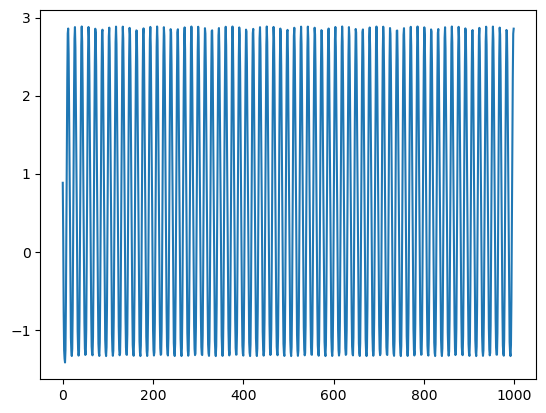

In [237]:
plt.plot(generated[:,0,0])

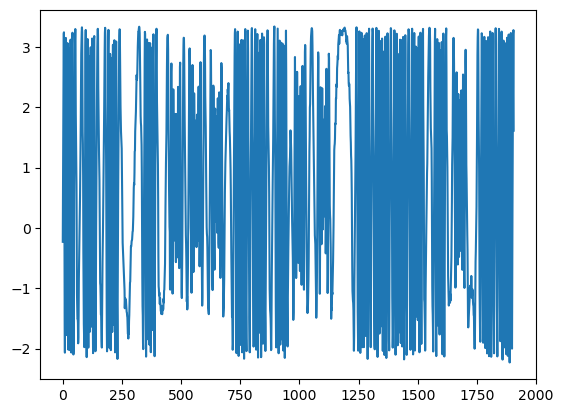

In [236]:
plt.plot(model(X_train)[:,0].detach().numpy())

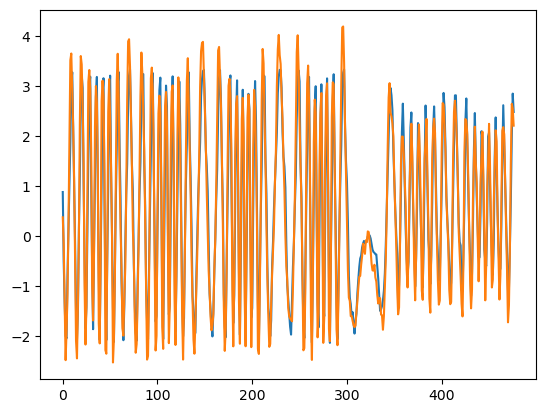

In [235]:
plt.plot(predictions[:,0])
plt.plot(unmixed[-predictions.shape[0]:,2,0])